# Introduction to Embeddings

This notebook provides a thorough introduction to the concept of embeddings.

## Setup libraries and functions.

We start by importing various libraries needed.

In [1]:
# Plots displayed inline in notebook
%matplotlib inline

# Make Python 3 consistent
from __future__ import print_function, division

# Make help libraries available
import sys

sys.path.append('/home/ubuntu/personal-libraries')

In [2]:
import pandas as pd
import numpy as np

from operator import itemgetter
from matplotlib import pyplot as plt

from keras.models import Model
from keras.layers import Input, Dense, Flatten, merge, Dropout
from keras.layers.merge import dot, add, concatenate
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.optimizers import Adam

from keras import backend as K
K.set_image_data_format('channels_first')

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


Setup paths and batch size. We work with the movielens dataset, and utilise the small dataset at first.

In [3]:
#path = "data/ml-20m/"
path = "data/movielens/ml-latest-small/"
model_path = 'models/recommender-intro/'

batch_size = 64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [4]:
ratings = pd.read_csv(path + 'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [6]:
movie_names = pd.read_csv(path + 'movies.csv').set_index('movieId')['title'].to_dict()

Define users and movies (as ids)

In [7]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

We define two dictionaries mapping each user and movie to a continous ordered integer.

In [8]:
userid2idx = {o:i for i, o in enumerate(users)}
movieid2idx = {o:i for i, o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [9]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

To get an overview of the structure of the data, we consider the max and min values.

In [10]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
                                            ratings.userId.max(),
                                            ratings.movieId.min(),
                                            ratings.movieId.max())

user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

So we have 671 users mapped to continous IDs and 9066 movies mapped to continous IDs. We check by considering the length of the objects.

In [11]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

We specify the number of latent factors in each embedding. This is a free parameter.

In [12]:
n_factors = 50

In [13]:
# Specify numpy seed, such that we get the same random sample each time
np.random.seed = 42

Randomly split into training and validation.

In [14]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [15]:
g = ratings.groupby('userId')['rating'].count()
topUsers = g.sort_values(ascending = False)[:15]

In [16]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending = False)[:15]

In [17]:
top_r = ratings.join(topUsers, rsuffix = '_r', how = 'inner', on = 'userId')

In [18]:
top_r = top_r.join(topMovies, rsuffix = '_r', how = 'inner', on = 'movieId')

In [19]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc = np.sum)

movieId,27,49,57,72,79,89,92,99,143,179,180,197,402,417,505
userId,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,3.0,4.0,4.0,5.0,2.0,5.0,5.0,4.0,5.0,5.0,2.0,5.0
29,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,5.0
72,4.0,5.0,5.0,4.0,5.0,3.0,4.5,5.0,4.5,5.0,5.0,5.0,4.5,5.0,4.0
211,5.0,4.0,4.0,3.0,5.0,3.0,4.0,4.5,4.0,NaN,3.0,3.0,5.0,3.0,NaN
212,2.5,NaN,2.0,5.0,NaN,4.0,2.5,NaN,5.0,5.0,3.0,3.0,4.0,3.0,2.0
293,3.0,NaN,4.0,4.0,4.0,3.0,NaN,3.0,4.0,4.0,4.5,4.0,4.5,4.0,NaN
310,3.0,3.0,5.0,4.5,5.0,4.5,2.0,4.5,4.0,3.0,4.5,4.5,4.0,3.0,4.0
379,5.0,5.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0
451,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,2.0,3.5,5.0


We can then consider the intuition of collavborative filtering in Excel.

In [20]:
from IPython.display import FileLink
FileLink('collab_filter.xlsx')

/home/ubuntu/deep-learning-intro/embedding-intro/collab_filter.xlsx

## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works. We build two simple embeddings, one for users and one for movies. Note the onedimensional input. Also note that we add regularisation.

In [21]:
user_in = Input(shape=(1, ), dtype = 'int64', name = 'user_in')
u = Embedding(n_users, n_factors, input_length = 1, embeddings_regularizer = l2(1e-4))(user_in)
movie_in = Input(shape=(1, ), dtype = 'int64', name = 'movie_in')
m = Embedding(n_movies, n_factors, input_length = 1, embeddings_regularizer = l2(1e-4))(movie_in)

We then merge the two input layers via the dotproduct of the two. Note in this case of collaborative filtering for recomender systems, we use embeddings of users and movies to save computation time. We could have one hot encoded the layers, but that would gie us giant matrices to multiply. Instead we use an embedding representation.

In [22]:
# Define model layers
# Note that axes has to be set to 2! Remember the order is (batches, channels, dim1)
x = dot([u, m], 2)
x = Flatten()(x)

# Initialise and compile the model
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss = 'mse')

Let's consider the model.

In [23]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

Train the model for a single epoch.

In [24]:
model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 1, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80182 samples, validate on 19822 samples
Epoch 1/1
80182/80182 [==============================] - 7s - loss: 10.0836 - val_loss: 4.3609


Increase the learning rate and run for 3 more epochs.

In [25]:
model.optimizer.lr = 0.01

model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 3, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80182 samples, validate on 19822 samples
Epoch 1/3
80182/80182 [==============================] - 8s - loss: 3.1591 - val_loss: 2.8027
Epoch 2/3
80182/80182 [==============================] - 7s - loss: 2.4009 - val_loss: 2.5966
Epoch 3/3
80182/80182 [==============================] - 7s - loss: 2.2253 - val_loss: 2.5490


Finally lower the learning rate again and train for 6 more epochs.

In [26]:
model.optimizer.lr=0.001
model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 6, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80182 samples, validate on 19822 samples
Epoch 1/6
80182/80182 [==============================] - 7s - loss: 2.1566 - val_loss: 2.5413
Epoch 2/6
80182/80182 [==============================] - 7s - loss: 2.1196 - val_loss: 2.5446
Epoch 3/6
80182/80182 [==============================] - 7s - loss: 2.0947 - val_loss: 2.5439
Epoch 4/6
80182/80182 [==============================] - 7s - loss: 2.0749 - val_loss: 2.5494
Epoch 5/6
80182/80182 [==============================] - 7s - loss: 2.0558 - val_loss: 2.5568
Epoch 6/6
80182/80182 [==============================] - 7s - loss: 2.0381 - val_loss: 2.5681


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

So we start by defining an embedding input layer.

In [27]:
def embedding_input(name, n_in, n_out, reg):
    
    inp = Input(shape=(1, ), dtype = 'int64', name = name)
    return inp, Embedding(n_in, n_out, input_length = 1, embeddings_regularizer = l2(reg))(inp)

And then create the actual embedding layers.

In [28]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

We then ddefine the bias terms. Note that this is just a one dimensional output embedding.

In [29]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length = 1)(inp)
    return Flatten()(x)

We then create the actual bias layers.

In [30]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

We then merge the input embeddings as we did before via the dot product, but now we also add the movie and user bias layers.

In [31]:
x = dot([u, m], 2)
x = Flatten()(x)
x = add([x, ub])
x = add([x, mb])

model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss = 'mse')

Let's inspect the model.

In [32]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_4 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

We then train the model for a single epoch with the default learning rate.

In [33]:
model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 1, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80182 samples, validate on 19822 samples
Epoch 1/1
80182/80182 [==============================] - 6s - loss: 8.8208 - val_loss: 3.4736


Next we increase the learning rate and train for 6 more epochs.

In [34]:
model.optimizer.lr = 0.01

model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 6, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80182 samples, validate on 19822 samples
Epoch 1/6
80182/80182 [==============================] - 6s - loss: 2.5885 - val_loss: 2.2928
Epoch 2/6
80182/80182 [==============================] - 6s - loss: 2.0044 - val_loss: 2.0965
Epoch 3/6
80182/80182 [==============================] - 6s - loss: 1.8436 - val_loss: 2.0074
Epoch 4/6
80182/80182 [==============================] - 6s - loss: 1.7489 - val_loss: 1.9286
Epoch 5/6
80182/80182 [==============================] - 6s - loss: 1.6688 - val_loss: 1.8626
Epoch 6/6
80182/80182 [==============================] - 6s - loss: 1.5948 - val_loss: 1.7947


Let's run for 6 more epochs.

Let's decrease the learning rate and run for 20 more epochs.

In [35]:
model.optimizer.lr = 0.001

model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 30, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80182 samples, validate on 19822 samples
Epoch 1/30
80182/80182 [==============================] - 6s - loss: 1.5239 - val_loss: 1.7339
Epoch 2/30
80182/80182 [==============================] - 6s - loss: 1.4530 - val_loss: 1.6738
Epoch 3/30
80182/80182 [==============================] - 6s - loss: 1.3851 - val_loss: 1.6082
Epoch 4/30
80182/80182 [==============================] - 6s - loss: 1.3184 - val_loss: 1.5539
Epoch 5/30
80182/80182 [==============================] - 6s - loss: 1.2535 - val_loss: 1.5046
Epoch 6/30
80182/80182 [==============================] - 6s - loss: 1.1914 - val_loss: 1.4516
Epoch 7/30
80182/80182 [==============================] - 6s - loss: 1.1322 - val_loss: 1.4085
Epoch 8/30
80182/80182 [==============================] - 6s - loss: 1.0760 - val_loss: 1.3639
Epoch 9/30
80182/80182 [==============================] - 6s - loss: 1.0226 - val_loss: 1.3231
Epoch 10/30
80182/80182 [==============================] - 6s - loss: 0.9732 - val_loss: 1.2881

Let's lower the learning rate even further, and see what that results in.

In [36]:
model.optimizer.lr = 0.0001
model.fit(x = [trn.userId, trn.movieId],
          y = trn.rating,
          batch_size = batch_size,
          epochs = 10, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80182 samples, validate on 19822 samples
Epoch 1/10
80182/80182 [==============================] - 6s - loss: 0.5487 - val_loss: 1.0091
Epoch 2/10
80182/80182 [==============================] - 6s - loss: 0.5459 - val_loss: 1.0092
Epoch 3/10
80182/80182 [==============================] - 6s - loss: 0.5437 - val_loss: 1.0096
Epoch 4/10
80182/80182 [==============================] - 6s - loss: 0.5420 - val_loss: 1.0100
Epoch 5/10
80182/80182 [==============================] - 6s - loss: 0.5399 - val_loss: 1.0109
Epoch 6/10
80182/80182 [==============================] - 6s - loss: 0.5383 - val_loss: 1.0108
Epoch 7/10
80182/80182 [==============================] - 6s - loss: 0.5369 - val_loss: 1.0111
Epoch 8/10
80182/80182 [==============================] - 6s - loss: 0.5359 - val_loss: 1.0118
Epoch 9/10
80182/80182 [==============================] - 6s - loss: 0.5346 - val_loss: 1.0126
Epoch 10/10
80182/80182 [==============================] - 6s - loss: 0.5338 - val_loss: 1.0133

This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach! (Jeremy was able to get < 0.9 level validation accuracy. I don't see how...

In [37]:
model.save_weights(model_path + 'bias.h5')

In [38]:
model.load_weights(model_path + 'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [39]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.77405691]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [40]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending = False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [41]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i, b in zip(topMovies, movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [42]:
sorted(movie_ratings, key = itemgetter(0))[:15]

[(-1.2483799, 'Battlefield Earth (2000)'),
 (-0.88680977, 'Blade: Trinity (2004)'),
 (-0.82273638, 'Speed 2: Cruise Control (1997)'),
 (-0.73856962, 'Howard the Duck (1986)'),
 (-0.73230171, 'Police Academy 6: City Under Siege (1989)'),
 (-0.70819014, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.68907702, 'Super Mario Bros. (1993)'),
 (-0.68780237, 'Jaws 3-D (1983)'),
 (-0.64648306, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.5096162, 'Wild Wild West (1999)'),
 (-0.49761289, 'House on Haunted Hill (1999)'),
 (-0.49373302, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.48490226, 'Police Academy 3: Back in Training (1986)'),
 (-0.48059863, 'Mouse Hunt (1997)'),
 (-0.4693388, 'Little Nicky (2000)')]

In [31]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.9800332, 'Band of Brothers (2001)'),
 (1.8893982, 'Killer, The (Die xue shuang xiong) (1989)'),
 (1.8802575, 'Modern Times (1936)'),
 (1.8379436, 'It Happened One Night (1934)'),
 (1.826431, 'African Queen, The (1951)'),
 (1.8237634, 'When We Were Kings (1996)'),
 (1.8214375, 'Shawshank Redemption, The (1994)'),
 (1.8087997, 'Ran (1985)'),
 (1.8068129, 'Seventh Seal, The (Sjunde inseglet, Det) (1957)'),
 (1.798604, 'Inherit the Wind (1960)'),
 (1.7861797, 'Mister Roberts (1955)'),
 (1.7714741, 'All About Eve (1950)'),
 (1.7638346, 'Wings of Desire (Himmel \xc3\xbcber Berlin, Der) (1987)'),
 (1.7424085, 'Shadowlands (1993)'),
 (1.7367874, 'Paprika (Papurika) (2006)')]

We can now do the same thing for the embeddings.

In [43]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. (Dimensionality reduction)

In [44]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
movie_pca = pca.fit(movie_emb.T).components_

In [45]:
fac0 = movie_pca[0]

In [46]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'classic' or small/independent.

In [47]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.12196557, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.093690522, 'Armageddon (1998)'),
 (0.08690089, 'Stargate (1994)'),
 (0.075494148, 'Titanic (1997)'),
 (0.070268199, 'Star Trek IV: The Voyage Home (1986)'),
 (0.069299027, 'Twister (1996)'),
 (0.066407703, 'Lethal Weapon 4 (1998)'),
 (0.062776968, 'X-Men (2000)'),
 (0.061271369, 'Star Trek: First Contact (1996)'),
 (0.061263155, 'Shrek 2 (2004)')]

In [48]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.1112565, 'Pulp Fiction (1994)'),
 (-0.10294075, '2001: A Space Odyssey (1968)'),
 (-0.089022465, 'Taxi Driver (1976)'),
 (-0.087269783, 'Clockwork Orange, A (1971)'),
 (-0.078771226, 'Fargo (1996)'),
 (-0.078720815,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'),
 (-0.077125475, 'Leaving Las Vegas (1995)'),
 (-0.076270372, 'Being John Malkovich (1999)'),
 (-0.075804256, 'Kill Bill: Vol. 1 (2003)'),
 (-0.07539016, 'Apocalypse Now (1979)')]

In [49]:
fac1 = movie_pca[1]

In [50]:
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [51]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.060048364, 'Room with a View, A (1986)'),
 (0.057672542, 'Showgirls (1995)'),
 (0.05471313, 'Annie Hall (1977)'),
 (0.051506702, 'Lives of Others, The (Das leben der Anderen) (2006)'),
 (0.05061977, 'Island of Dr. Moreau, The (1996)'),
 (0.050522573, 'Bringing Up Baby (1938)'),
 (0.050494485, 'Beverly Hills Cop III (1994)'),
 (0.050385468, 'Charlie and the Chocolate Factory (2005)'),
 (0.048418894, 'Postman, The (Postino, Il) (1994)'),
 (0.04761783, 'Johnny Mnemonic (1995)')]

In [52]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.17309916, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.16267596, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.15139943, 'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.14101848, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.13299222, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.12427777, 'Dances with Wolves (1990)'),
 (-0.11693659, 'Gladiator (2000)'),
 (-0.11682141, 'Braveheart (1995)'),
 (-0.1115991, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.10980464, 'Saving Private Ryan (1998)')]

In [53]:
fac2 = movie_pca[2]

In [54]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'. Or more likely kid friendly vs. not that.

In [55]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.13095675, 'Beauty and the Beast (1991)'),
 (0.13017455, "Schindler's List (1993)"),
 (0.12257041, 'Babe (1995)'),
 (0.097246774, 'Finding Nemo (2003)'),
 (0.094979852, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (0.085286386, 'Dances with Wolves (1990)'),
 (0.082843579, 'Aladdin (1992)'),
 (0.081177749, 'While You Were Sleeping (1995)'),
 (0.077307083, 'Pleasantville (1998)'),
 (0.076036908, 'Sling Blade (1996)')]

In [56]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.088475332, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.085122056, 'Total Recall (1990)'),
 (-0.081604391, 'Eyes Wide Shut (1999)'),
 (-0.077283323, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (-0.076373912, 'American Pie (1999)'),
 (-0.074788116, 'Back to the Future Part II (1989)'),
 (-0.072529912, 'Zoolander (2001)'),
 (-0.070622489, 'American Psycho (2000)'),
 (-0.069049798, 'Event Horizon (1997)'),
 (-0.067004152, 'Austin Powers: International Man of Mystery (1997)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [57]:
import sys
stdout, stderr = sys.stdout, sys.stderr # save notebook stdout and stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr # restore notebook stdout and stderr

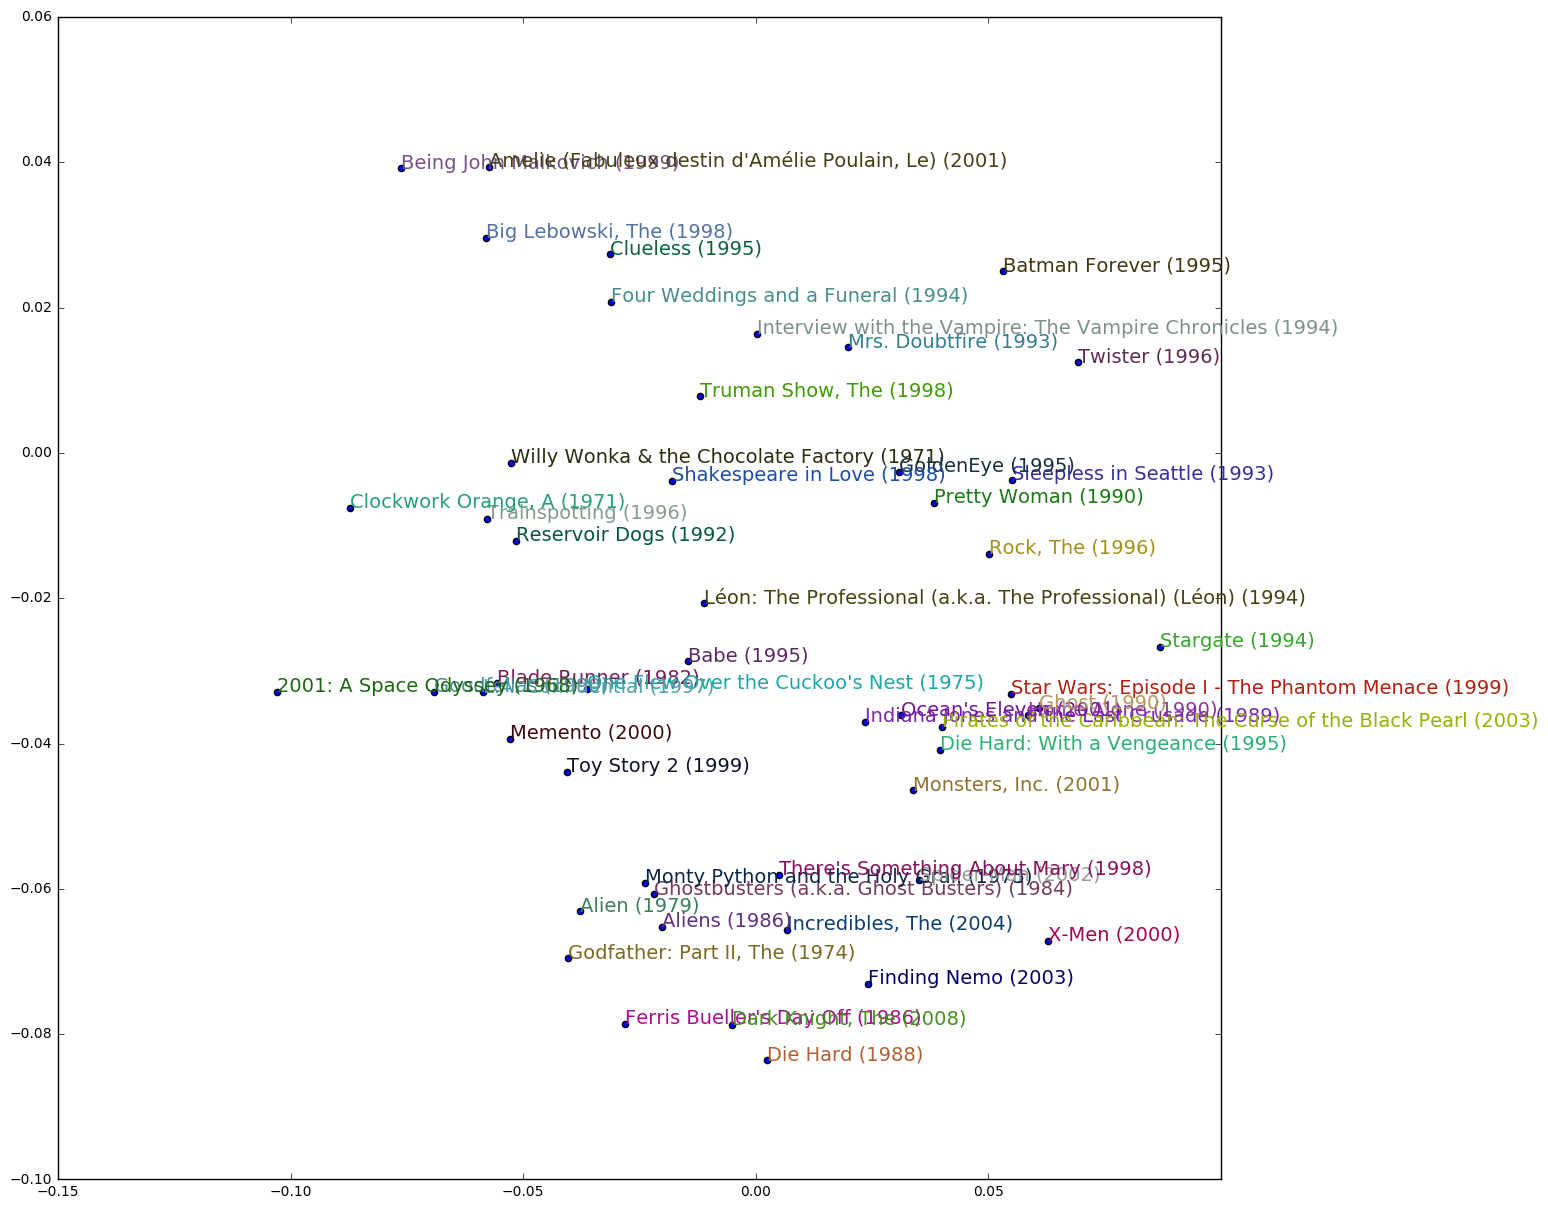

In [59]:
start = 50; end = 100
X = fac0[start:end]
Y = fac1[start:end]
plt.figure(figsize = (15, 15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color = np.random.rand(3) * 0.7, fontsize = 14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [60]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [61]:
x = concatenate([u, m])
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)

nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

Let's inspect the model

In [62]:
nn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
user_in (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
movie_in (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
embedding_7 (Embedding)          (None, 1, 50)         33550       user_in[0][0]                    
____________________________________________________________________________________________________
embedding_8 (Embedding)          (None, 1, 50)         453300      movie_in[0][0]                   
___________________________________________________________________________________________

We then train the model

In [64]:
nn.fit(x = [trn.userId, trn.movieId],
       y = trn.rating,
       batch_size = batch_size,
       epochs = 8, 
       validation_data = ([val.userId, val.movieId], val.rating))

Train on 80182 samples, validate on 19822 samples
Epoch 1/8
80182/80182 [==============================] - 8s - loss: 2.4778 - val_loss: 0.9190
Epoch 2/8
80182/80182 [==============================] - 8s - loss: 1.4765 - val_loss: 0.8456
Epoch 3/8
80182/80182 [==============================] - 8s - loss: 1.2391 - val_loss: 0.8565
Epoch 4/8
80182/80182 [==============================] - 8s - loss: 1.0381 - val_loss: 0.8251
Epoch 5/8
80182/80182 [==============================] - 8s - loss: 0.9161 - val_loss: 0.8239
Epoch 6/8
80182/80182 [==============================] - 8s - loss: 0.8515 - val_loss: 0.8193
Epoch 7/8
80182/80182 [==============================] - 8s - loss: 0.8222 - val_loss: 0.8121
Epoch 8/8
80182/80182 [==============================] - 8s - loss: 0.8106 - val_loss: 0.8156


This improves on our already impressive accuracy even further!

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [65]:
g = ratings.groupby('movieId')['rating'].count()
topMovies = g.sort_values(ascending = False)[:2000]
topMovies = np.array(topMovies.index)

We now cannot consider the bias terms. Only the embeddings.

In [66]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use PCA to simplify them down to just 3 vectors.

In [67]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
movie_pca = pca.fit(movie_emb.T).components_

In [68]:
fac0 = movie_pca[0]

In [69]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic' or small/independent.

In [70]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.063787073, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (0.059591539, 'Bio-Dome (1996)'),
 (0.058219712,
  'Highlander III: The Sorcerer (a.k.a. Highlander: The Final Dimension) (1994)'),
 (0.055813853, 'Richie Rich (1994)'),
 (0.055807684, 'Howard the Duck (1986)'),
 (0.054875892, 'Police Academy 6: City Under Siege (1989)'),
 (0.054144073, 'Battlefield Earth (2000)'),
 (0.053640887, 'Police Academy 4: Citizens on Patrol (1987)'),
 (0.053209398, 'Super Mario Bros. (1993)'),
 (0.053178709, 'Vampire in Brooklyn (1995)')]

In [71]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.064379044, 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)'),
 (-0.061002802, 'African Queen, The (1951)'),
 (-0.058440961, 'Godfather, The (1972)'),
 (-0.05636587, '12 Angry Men (1957)'),
 (-0.056362662, 'All About Eve (1950)'),
 (-0.055711143, 'Roger & Me (1989)'),
 (-0.055568933, 'Third Man, The (1949)'),
 (-0.05491244, 'Shawshank Redemption, The (1994)'),
 (-0.052504547, 'Dark Knight, The (2008)'),
 (-0.052213129, 'Maltese Falcon, The (1941)')]

In [72]:
fac1 = movie_pca[1]

In [73]:
movie_comp = [(f, movie_names[movies[i]]) for f, i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [74]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.076756738, 'Cocoon (1985)'),
 (0.075398959, 'Natural Born Killers (1994)'),
 (0.07367868, 'Reality Bites (1994)'),
 (0.073647559, 'Blade (1998)'),
 (0.07317929, 'Prophecy, The (1995)'),
 (0.072365306, 'Mallrats (1995)'),
 (0.070607632, 'Babe: Pig in the City (1998)'),
 (0.070193529, 'Beautiful Girls (1996)'),
 (0.06965296, 'Royal Tenenbaums, The (2001)'),
 (0.068619497,
  'Englishman Who Went Up a Hill But Came Down a Mountain, The (1995)')]

In [75]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.071003713, 'Police Academy 6: City Under Siege (1989)'),
 (-0.063338719, 'Richie Rich (1994)'),
 (-0.061640132, 'Con Air (1997)'),
 (-0.057983983, 'Sweet Home Alabama (2002)'),
 (-0.053749893, 'Monsters, Inc. (2001)'),
 (-0.051338352, 'Negotiator, The (1998)'),
 (-0.049891856, 'My Fair Lady (1964)'),
 (-0.049747411, 'Anger Management (2003)'),
 (-0.049429294, 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)'),
 (-0.048499685, 'Entrapment (1999)')]

In [76]:
fac2 = movie_pca[2]

In [77]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'. Or more likely kid friendly vs. not that.

In [78]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:10]

[(0.078021906, 'On Golden Pond (1981)'),
 (0.068144485, 'Blues Brothers, The (1980)'),
 (0.06707678, 'Fargo (1996)'),
 (0.062286425, "Knight's Tale, A (2001)"),
 (0.06073596, "Emperor's New Groove, The (2000)"),
 (0.058741905, 'Michael (1996)'),
 (0.058587585, 'Man with Two Brains, The (1983)'),
 (0.058118045, "What's Love Got to Do with It? (1993)"),
 (0.057872057, 'Net, The (1995)'),
 (0.05773899, 'Aliens (1986)')]

In [79]:
sorted(movie_comp, key = itemgetter(0))[:10]

[(-0.08292298, 'Hangover, The (2009)'),
 (-0.079714045, '300 (2007)'),
 (-0.075041503, 'Honey, I Shrunk the Kids (1989)'),
 (-0.068030663, 'Great Dictator, The (1940)'),
 (-0.067085706, 'Adventures in Babysitting (1987)'),
 (-0.065544389, 'Tangled (2010)'),
 (-0.063109457, 'Legally Blonde (2001)'),
 (-0.062594831, 'Wedding Planner, The (2001)'),
 (-0.061620526, 'Arachnophobia (1990)'),
 (-0.061296653, 'Star Trek: First Contact (1996)')]